# Showing the endpoints of single stars for differen Z and M ZAMS

re-scaling the y-axis to represent a Salpeter IMF

In [87]:
import h5py as h5
import pandas as pd
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from astropy.table import Table
import sys
sys.path.append('run_data')
from definitions import sim_flags_dict

import os
home_dir = os.path.expanduser("~")

from subprocess import Popen, PIPE
import subprocess

######################################
## PLOT setttings
plt.rc('font', family='serif')
rc('text', usetex=False)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30, 18,20,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)     # legend fontsize


#################################################################
##   Parameters to set
#################################################################
sim_name        = "OldWinds_RemFryer2012"#"OldWinds_RemFryer2012" # sim_name determines which flags to run COMPAS with
root_out_dir    = f"/mnt/home/lvanson/ceph/CompasOutput/v02.46.01/{sim_name}"


# Run a grid of effectively single stars 

In [86]:
# Check if sim_name exists in the dictionary
if sim_name in sim_flags_dict:
    sim_variation_flags = sim_flags_dict[sim_name]
    print(sim_variation_flags)
else:
    print(f"Unknown sim_name: {sim_name}")


--mass-loss-prescription BELCZYNSKI2010 --OB-mass-loss VINK2001 --VMS-mass-loss VINK2011 --RSG-mass-loss NJ90 --WR-mass-loss BELCZYNSKI2010  --remnant-mass-prescription FRYER2012 --kick-magnitude-distribution MAXWELLIAN 


In [105]:
#################################################################
##   Write a grid of Single stars to root_out_dir
#################################################################
Z_array         = np.logspace(-4,np.log10(0.03), num=100) 
sma             = 100000.

# Make a folder to store the Single star grids if it doesn't exist yet
if not os.path.exists(root_out_dir + '/SingleStarGrids'):
    os.makedirs(root_out_dir + '/SingleStarGrids')

# Copy the output definitions
# os.system(f'cp /{home_dir}/ZdependentFormEff/run_data/COMPAS_Output_Definitions.txt {root_out_dir}/SingleStarGrids/')

grid_file_name = f'Single_star_metallicities.txt'

#################################################################
# Write the grid
with open( f'{root_out_dir}/SingleStarGrids/{grid_file_name}' , 'w') as f:
    # Write a grid file of len mass_array
    for i in range(len(Z_array)):
        # write the line
        f.write(f'--random-seed {i}  --metallicity {Z_array[i]} --semi-major-axis {sma} \n ' )



In [169]:
#################################################################
container_name = f'SingleStars_mass_Z'

# open a file to write the tasks to 
with open(f'{root_out_dir}/SingleStarGrids/Single_StarTasks', 'w') as f:

    # low masses: 1 Msun increment [start, count, increment]
    general_flags = f" --initial-mass-1 'r[3, 20, 0.5]' --grid '{root_out_dir}/SingleStarGrids/{grid_file_name}' --add-options-to-sysparms 'NEVER' --output-container 'SingleStars_lowmass_Z' " # --detailed-output True --logfile-definitions 'COMPAS_Output_Definitions.txt' "
    task_line = f"cd {root_out_dir}/SingleStarGrids/ ; module load python gsl boost hdf5 ; $COMPAS_ROOT_DIR/src/COMPAS {general_flags + sim_variation_flags}  > SingleStars_metals_lowM.log 2>&1 " 
    f.write(task_line + '\n')

    # medium masses: 2 Msun increment [start, count, increment]
    general_flags = f" --initial-mass-1 'r[12, 5, 2]' --grid '{root_out_dir}/SingleStarGrids/{grid_file_name}' --add-options-to-sysparms 'NEVER' --output-container 'SingleStars_midmass_Z' " # --detailed-output True --logfile-definitions 'COMPAS_Output_Definitions.txt' "
    task_line = f"cd {root_out_dir}/SingleStarGrids/ ; module load python gsl boost hdf5 ; $COMPAS_ROOT_DIR/src/COMPAS {general_flags + sim_variation_flags}  > SingleStars_metals_midM.log 2>&1 " 
    f.write(task_line + '\n')

    # high masses: 2 Msun increment [start, count, increment]
    general_flags = f" --initial-mass-1 'r[30, 12, 10]' --grid '{root_out_dir}/SingleStarGrids/{grid_file_name}' --add-options-to-sysparms 'NEVER' --output-container 'SingleStars_highmass_Z' " # --detailed-output True --logfile-definitions 'COMPAS_Output_Definitions.txt' "
    task_line = f"cd {root_out_dir}/SingleStarGrids/ ; module load python gsl boost hdf5 ; $COMPAS_ROOT_DIR/src/COMPAS {general_flags + sim_variation_flags}  > SingleStars_metals_highM.log 2>&1 " 
    f.write(task_line + '\n')


## !!!! NOTE this broken, but it's just 3 tasks, so I ran them manually
# Run the tasks with DisBatch disBatch Command
# command = f"module load disBatch && sbatch -p gen -n 4 disBatch {root_out_dir}/SingleStarGrids/Single_StarTasks"
# result = subprocess.run(command, shell=True, capture_output=True, text=True)

    

# Convey constant weight in IMF

I'm trying to represent the y-axis relative to the IMF weights. 
Assuming that the IMF follows the powerlaw: 

\begin{equation}
PDF = m^{-\alpha} 
\end{equation}

For a Salpeter IMF, we use $\alpha = 2.3$
then the CDF

\begin{equation}
CDF = \int_{-inf}^{x} m^{-2.3} dm  = \frac{-1}{1.3} x^{-1.3}
\end{equation}


The probability for some value to be in a bin is $CDF(y_i + \Delta y) - CDF(y_i)$ <br>
I'm tring to solve when this will be constant. I.e., I'm looking for a function of $\Delta y$ such that 

\begin{equation}
 CDF(y_i + \Delta y) - CDF(y_i)  = const 
\end{equation}

writing this out we get

\begin{equation}
 \frac{-1}{\alpha - 1} \Biggl( y_i + \Delta y \Biggr) ^{-\alpha + 1} + \frac{1}{\alpha - 1} y_i^{-\alpha + 1} = const 
\end{equation}

or again with $\alpha = 2.3$ 

\begin{equation}
 \frac{-1}{1.3} \Biggl( y_i + \Delta y \Biggr) ^{-1.3} + \frac{1}{1.3} y_i^{-1.3} = c 
\end{equation}

Solving this for $\Delta y$ we get:

\begin{equation}
\boxed{
 \Delta y = \Biggl( y^{(1-\alpha)} - c * (\alpha-1) \Biggr)^{1/(1-\alpha)}  - y
}
\end{equation}



In [122]:
# Equation to determine the delta_y needed to get a constant CDF
def delta_y(y, a = 2.3, c = 1e-3):
    """
    y: y value to start from
    Assuming a powerlaw: x**-a
    a: power law index 
    c: constant CDF difference, 
    e.g., how 'probable' you want your bin step to be
    """
    return (y**(1-a) - c * (a-1) )**(1/(1-a))  - y

    
# Bottom value of your y array
y_start = 5
const   = 1e-4 #5e-3

# Itteratively calculate the y values
Y_ticks = [y_start]
y = y_start
while y < 200: 
    dy = delta_y(y, a = 2.3, c = const) 
    print('y', y, 'dy', dy, 'y+dy', y+dy)
    y += dy
    Y_ticks.append(y)
    
print('Y_ticks', len(Y_ticks) , Y_ticks,  )

print('constant CDF? ', np.unique(-1/1.3 * np.array([Y_ticks[i]**-1.3 - Y_ticks[i+1]**-1.3 for i in range(len(Y_ticks)-1)]) ))



y 5 dy 0.004055420800503029 y+dy 5.004055420800503
y 5.004055420800503 dy 0.004062994147493448 y+dy 5.0081184149479965
y 5.0081184149479965 dy 0.004070589654654455 y+dy 5.012189004602651
y 5.012189004602651 dy 0.004078207410338486 y+dy 5.016267212012989
y 5.016267212012989 dy 0.00408584750334029 y+dy 5.02035305951633
y 5.02035305951633 dy 0.004093510022908475 y+dy 5.024446569539238
y 5.024446569539238 dy 0.004101195058739293 y+dy 5.0285477645979775
y 5.0285477645979775 dy 0.004108902700984629 y+dy 5.032656667298962
y 5.032656667298962 dy 0.004116633040253781 y+dy 5.036773300339216
y 5.036773300339216 dy 0.004124386167617011 y+dy 5.040897686506833
y 5.040897686506833 dy 0.004132162174606435 y+dy 5.045029848681439
y 5.045029848681439 dy 0.004139961153217797 y+dy 5.049169809834657
y 5.049169809834657 dy 0.004147783195919352 y+dy 5.0533175930305765
y 5.0533175930305765 dy 0.004155628395649202 y+dy 5.057473221426226
y 5.057473221426226 dy 0.004163496845818848 y+dy 5.0616367182720445
y 5.061

# Read the grid of single stars

In [174]:
keys_of_interest = ['Metallicity@ZAMS(1)', 'Mass@ZAMS(1)','Stellar_Type(1)']
ALL_SYS = pd.DataFrame()

# For each mass, compute the values and append them to the lists
# for mass in [10, 20, 30, 40, 50, 60, 70,90, 100, 150]:
    # print('mass', mass)
locations = ['SingleStars_lowmass_Z', 'SingleStars_midmass_Z', 'SingleStars_highmass_Z']

for folder in locations:
    loc = f'{root_out_dir}/SingleStarGrids/{folder}/'#SingleStars_mass_Z
    print(loc)
    # Read summary HDF5 datasets as pandas dataframes
    with h5.File(f'{loc}/COMPAS_Output.h5', 'r') as All_data:
        SYS = pd.DataFrame()
        for key in keys_of_interest:
            SYS[key] = All_data['BSE_System_Parameters'][key][()]

    # Append the data to the ALL_SYS dataframe
    ALL_SYS = pd.concat([ALL_SYS, SYS], ignore_index=True)

display(ALL_SYS)
# print(list(SYS.keys))
# detailed_data = f'{loc}/Detailed_Output/BSE_Detailed_Output_{i}.h5'
# detailh5 = h5.File(detailed_data, 'r')



/mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/SingleStarGrids/SingleStars_lowmass_Z/
/mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/SingleStarGrids/SingleStars_midmass_Z/
/mnt/home/lvanson/ceph/CompasOutput/v02.46.01/OldWinds_RemFryer2012/SingleStarGrids/SingleStars_highmass_Z/


,Metallicity@ZAMS(1),Mass@ZAMS(1),Stellar_Type(1)
0,0.000100,3.0,11
1,0.000106,3.0,11
2,0.000112,3.0,11
3,0.000119,3.0,11
4,0.000126,3.0,11
...,...,...,...
3695,0.023825,140.0,14
3696,0.025238,140.0,14
3697,0.026735,140.0,14
3698,0.028320,140.0,14


In [175]:
# # Mapping types to names 
# Stellar_Type_table = Table()
# Stellar_Type_table['types'] = ['MS_low', 'MS' ,'HG', 'AGB', 'CHeB', 'EAGB','TPAGB','HeMS','HeHG','HeGB','HeWD','COWD','ONeWD','NS','BH','massless remnant']
# Stellar_Type_table['indices'] = np.arange(len(Stellar_Type_table))

Stellar_Type_table = Table()
Stellar_Type_table['types'] = ['HeWD','COWD','ONeWD','NS','BH','massless remnant']
Stellar_Type_table['indices'] = np.arange(10, 16)


# Now let's scale our y axis

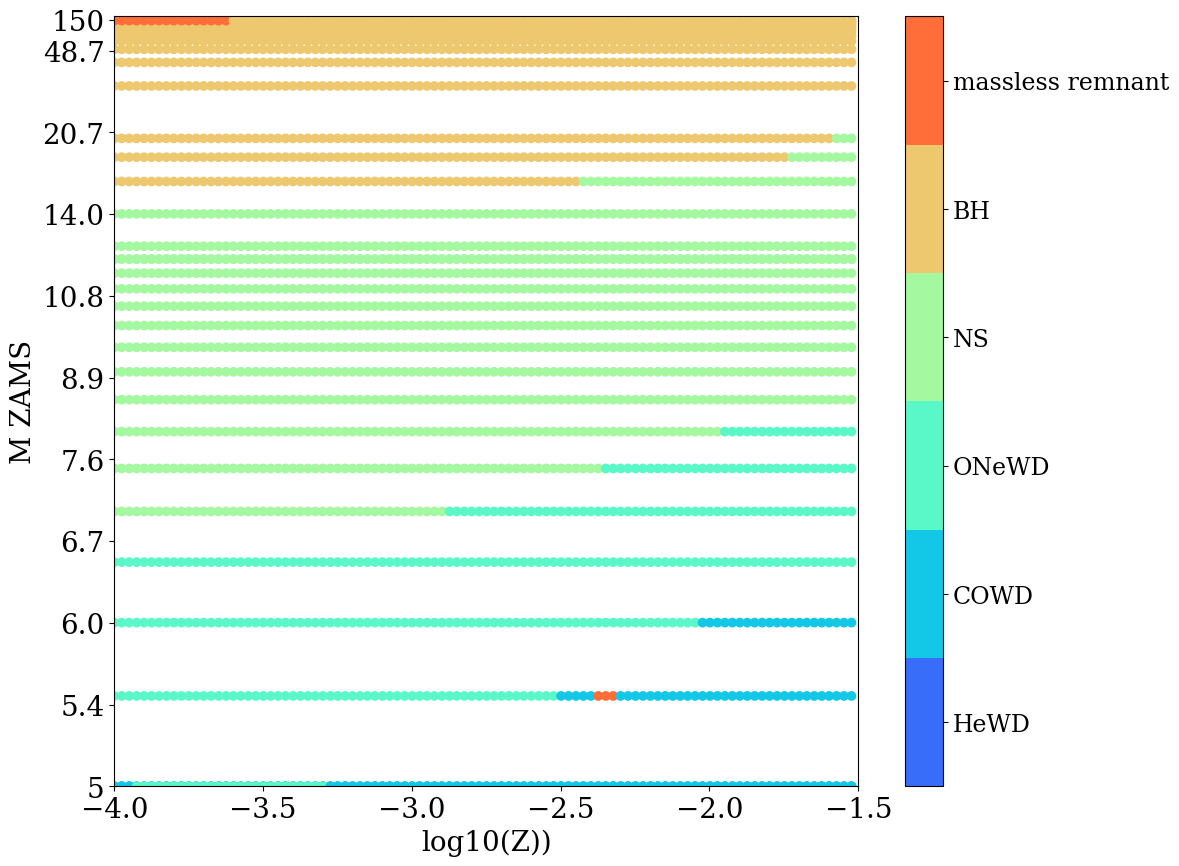

In [176]:
##########################
# START PLOTTING
##########################
fig, ax = plt.subplots(figsize=(12, 10))

# First define new y values
new_Y_ticks = np.linspace(0, 1, len(Y_ticks))

#######
# Make cmap for stellar types
col_map_table = Stellar_Type_table
newcmp = ListedColormap(sns.color_palette("rainbow", len(col_map_table))) 

# map your old y values to the new y values using np.interp
im = ax.scatter(np.log10(ALL_SYS['Metallicity@ZAMS(1)']), np.interp(ALL_SYS['Mass@ZAMS(1)'], Y_ticks, new_Y_ticks), 
                c = ALL_SYS['Stellar_Type(1)'], cmap = newcmp,  marker = 'o', 
                vmin = min(col_map_table['indices']) -0.5, vmax= max(col_map_table['indices']) + 0.5)

# Create the colorbar
cb = plt.colorbar(im, ticks=col_map_table['indices'])
cb.ax.set_yticklabels(col_map_table['types'], size = 17)

# Set the y-ticks and y-ticklabels
yticks = new_Y_ticks[::100]
yticklabels = [np.round(y,1) for y in Y_ticks[::100]]
#I also want to show 150
yticks = np.append(yticks, np.interp(150, Y_ticks, new_Y_ticks))
yticklabels.append(150)
#
ax.set_yticks(yticks)
ax.yaxis.set_ticklabels(yticklabels) # change the ticks' names to y

ax.set_xlim(-4, -1.5)
ax.set_ylim(new_Y_ticks[0], new_Y_ticks[-1])

#######
ax.set_xlabel('log10(Z))')
ax.set_ylabel('M ZAMS')


plt.show()

In [177]:
from scipy.interpolate import interp1d

# Get unique stellar types
unique_types = np.unique(ALL_SYS['Stellar_Type(1)'][ALL_SYS['Stellar_Type(1)'] > 9])

# Create a dictionary to store the interpolation functions
interp_funcs = {}

# Loop over unique types
for stellar_type in unique_types:
    # Filter the DataFrame by the current stellar type
    ALL_SYS_type = ALL_SYS[ALL_SYS['Stellar_Type(1)'] == stellar_type]
    
    # Group by 'Metallicity@ZAMS(1)' and find the maximum 'M_ZAMS' for each group
    ALL_SYS_type_grouped = ALL_SYS_type.groupby('Metallicity@ZAMS(1)')['Mass@ZAMS(1)'].max().reset_index()
    
    # Sort the DataFrame by 'Metallicity@ZAMS(1)'
    ALL_SYS_type_sorted = ALL_SYS_type_grouped.sort_values(by='Metallicity@ZAMS(1)')
    
    # Create the interpolation function and store it in the dictionary
    interp_funcs[stellar_type] = interp1d(ALL_SYS_type_sorted['Metallicity@ZAMS(1)'], ALL_SYS_type_sorted['Mass@ZAMS(1)'], kind='cubic', fill_value="extrapolate")

# Now you can use the functions in the interp_funcs dictionary to get interpolated 'Mass@ZAMS(1)' values for given 'Metallicity@ZAMS(1)' values and 'Stellar_Type(1)' values
# For example:
stellar_type = 13
metallicity = 0.02
m_zams_interpolated = interp_funcs[stellar_type](metallicity)
print(f"The interpolated maximum M_ZAMS for Metallicity@ZAMS(1) = {np.log10(metallicity)} and Stellar_Type(1) = {stellar_type} is {m_zams_interpolated}")

print(interp_funcs)


The interpolated maximum M_ZAMS for Metallicity@ZAMS(1) = -1.6989700043360187 and Stellar_Type(1) = 13 is 18.0156133930363
{11: <scipy.interpolate._interpolate.interp1d object at 0x1554e91e1b30>, 12: <scipy.interpolate._interpolate.interp1d object at 0x1554e85c05e0>, 13: <scipy.interpolate._interpolate.interp1d object at 0x1554eb4533b0>, 14: <scipy.interpolate._interpolate.interp1d object at 0x1554e921ae50>, 15: <scipy.interpolate._interpolate.interp1d object at 0x1554e77dc400>}


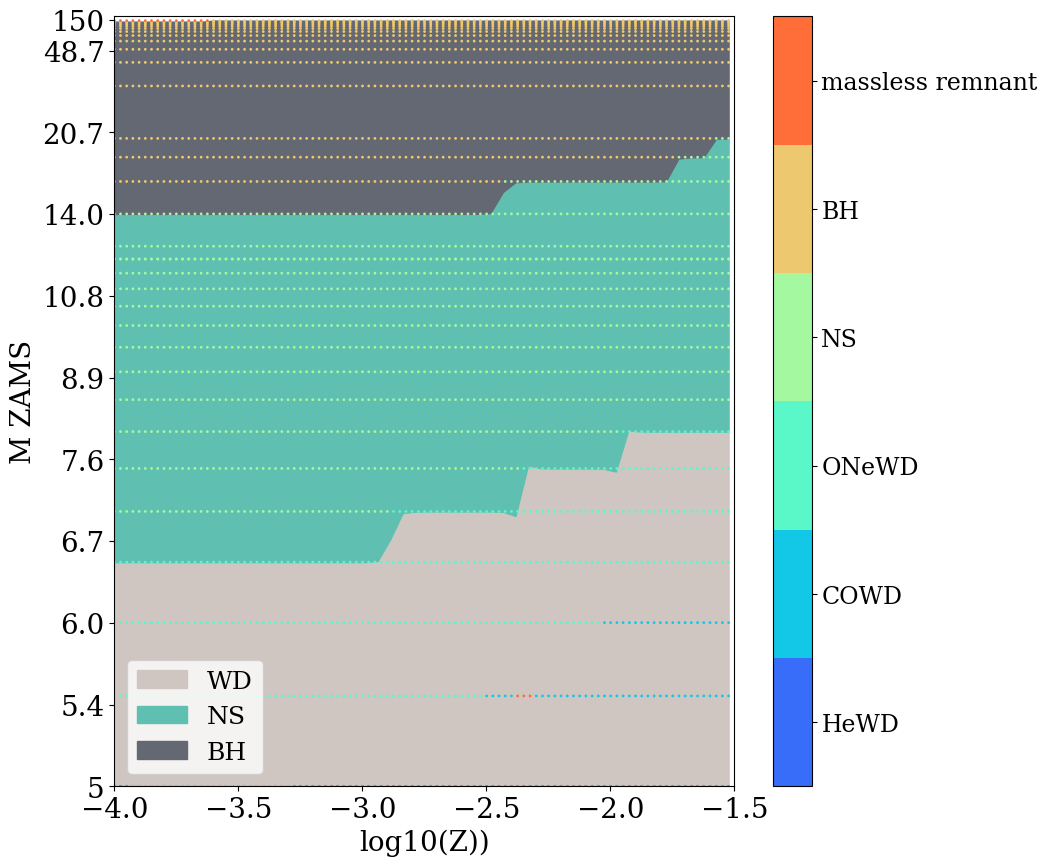

In [182]:
# Colors
color_dict = {14: '#646873', 
            #   'BHNS': '#377CB7',#'#4D7DAF', #'#e8485a', 
              13: '#5FC0B2',#'#8ECCF2', #'#8CBFDA',#'#778FD2',#91c74c',
              12: '#cfc6c2'}
            #   'masslessRemnants': '#000000',
            #   'StellarMergers': '#F0C26B', #'#DDBD76'
            #   'UnboundSystems': '#b0c4dd'} #'#F4C6B9'

metallicities = np.logspace(-4, np.log10(0.03), num=50)

###############
fig, ax = plt.subplots(figsize = (10,10))


###################
# fill with interpolated
# WD
WD_max_mzams = interp_funcs[12](metallicities)
ax.fill_between(np.log10(metallicities), y1 = 0, y2= np.interp(WD_max_mzams, Y_ticks, new_Y_ticks),  
            label = 'WD', color = color_dict[12])

# NS
NS_max_mzams = interp_funcs[13](metallicities)
ax.fill_between(np.log10(metallicities), y1 = np.interp(WD_max_mzams, Y_ticks, new_Y_ticks), y2= np.interp(NS_max_mzams, Y_ticks, new_Y_ticks),  
            label = 'NS', color = color_dict[13])

# BH
BH_max_mzams = interp_funcs[14](metallicities)
ax.fill_between(np.log10(metallicities), y1 = np.interp(NS_max_mzams, Y_ticks, new_Y_ticks), y2= np.interp(BH_max_mzams, Y_ticks, new_Y_ticks),  
            label = 'BH', color = color_dict[14])

##########
# scatter plot 
col_map_table = Stellar_Type_table
newcmp = ListedColormap(sns.color_palette("rainbow", len(col_map_table))) 

# map your old y values to the new y values using np.interp
im = ax.scatter(np.log10(ALL_SYS['Metallicity@ZAMS(1)']), np.interp(ALL_SYS['Mass@ZAMS(1)'], Y_ticks, new_Y_ticks), 
                c = ALL_SYS['Stellar_Type(1)'], cmap = newcmp,  marker = 'o', 
                vmin = min(col_map_table['indices']) -0.5, vmax= max(col_map_table['indices']) + 0.5, s = 1)

# Create the colorbar
cb = plt.colorbar(im, ticks=col_map_table['indices'])
cb.ax.set_yticklabels(col_map_table['types'], size = 17)


##########
# Set the y-ticks and y-ticklabels
yticks = new_Y_ticks[::100]
yticklabels = [np.round(y,1) for y in Y_ticks[::100]]
#I also want to show 150
yticks = np.append(yticks, np.interp(150, Y_ticks, new_Y_ticks))
yticklabels.append(150)
#
ax.set_yticks(yticks)
ax.yaxis.set_ticklabels(yticklabels) # change the ticks' names to y

ax.set_xlim(-4, -1.5)
ax.set_ylim(new_Y_ticks[0], new_Y_ticks[-1])

#######
ax.set_xlabel('log10(Z))')
ax.set_ylabel('M ZAMS')

ax.legend()
plt.savefig(f'../plots/M_ZAMS_Type_perZ.pdf',bbox_inches='tight')
plt.show()
